# A tool for MAST wave characterisation

## Setup
Identify time ranges into which to separate the analysis. Locate crash times and define widows just before and just after them. Various plots shown to indicate suitability of ranges and windows.


Import necessary packages

In [1]:
from lib.imports_BES import *
from lib.analysis_functions_BES import *
from lib.analysis_functions_Mirnov import *
from lib.analysis_functions_general import *

# Specify path to where data is stored
bes_data_path = "BES_code_local/Data/"
mirnov_data_path = "Mirnov_code_local/Data/"
shot = 29378
shotlabel = "\#" + str(shot)

# Some things that might be useful for plotting
colours = ["r", "g", "b", "c", "m", "y", "k"]
markers = ["x", "o", "s", "^", "*", "+", "d"]

Load BES data from various NETCDF files

In [2]:
# (R, z) locations for the BES channels. Shape: (32,2)
apdpos = np.asarray(xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_apdpos.nc"))

# Main BES data. Array for times and shape (32,time) array for fluctuation
fluct_data_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_LH_fluct_data.nc")
bes_time = np.asarray(fluct_data_from_file.coords['time'])
fluct_data = np.asarray(fluct_data_from_file)
f_samp_BES = 1/np.mean(np.diff(bes_time))

Load Mirnov coil data

In [3]:
# Get coil positions
coilpos = np.asarray(xr.open_dataarray(mirnov_data_path + "coil_positions.nc"))

# Main Mirnov data
mirnov_data_from_file = xr.open_dataarray(mirnov_data_path + "shot" + str(shot) + "_mirnov_data.nc")
mirnov_time = np.asarray(mirnov_data_from_file.coords['time'])
coil_nums = np.asarray(mirnov_data_from_file.coords['coil']) # Coil numbers e.g. 210 for coils in order of data
mirnov_data = np.asarray(mirnov_data_from_file) # Shape (11,650000)
f_samp_mirnov = 1/np.mean(np.diff(mirnov_time))

# Useful coils appear to be [206, 207, 210, 212, 213, 214]
coil_nums = coil_nums[1:7]
mirnov_data = mirnov_data[1:7]
coilpos = coilpos[1:7]

Load other diagnostics

In [4]:
# Dalpha data. Array for time and array for values
dalpha_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_dalpha.nc")
dalpha_time = np.asarray(dalpha_from_file.coords['time'])
dalpha_data = np.asarray(dalpha_from_file)

# Upper tangential Dalpha. Array for time and array for values
utda_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_upper_tan_dalpha.nc")
utda_time = np.asarray(utda_from_file.coords['time'])
utda_data = np.asarray(utda_from_file)

# Line-averaged density. Array for time and array for values
density_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_density.nc")
density_time = np.asarray(density_from_file.coords['time'])
density_data = np.asarray(density_from_file)

# Equilibria from EFIT. Two spacial arrays, a time array and 2D array of psi
equilib_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_equilibria.nc")
equilib_time = np.asarray(equilib_from_file.coords['time'])
equilib_R = np.asarray(equilib_from_file.coords['R'])
equilib_Z = np.asarray(equilib_from_file.coords['Z'])
equilib_psi = np.asarray(equilib_from_file)

Define regions of interest based on $D_\alpha$ data plotting just below

In [5]:
# Change regions' bounds as needed
regions = [[0.16,0.24], [0.36,0.54], [0.54,0.68]]

# BES time is limited to ~0.65
for i in range(len(regions)):
    if regions[i][1] > bes_time[-1]:
        print("Region", i, "trimmed", str(regions[i]), "to", np.around([regions[i][0], bes_time[-1]],2))
        regions[i] = [regions[i][0], bes_time[-1]]

Region 2 trimmed [0.54, 0.68] to [0.54 0.65]


Plot regions so time ranges defined above can be fine-tuned.

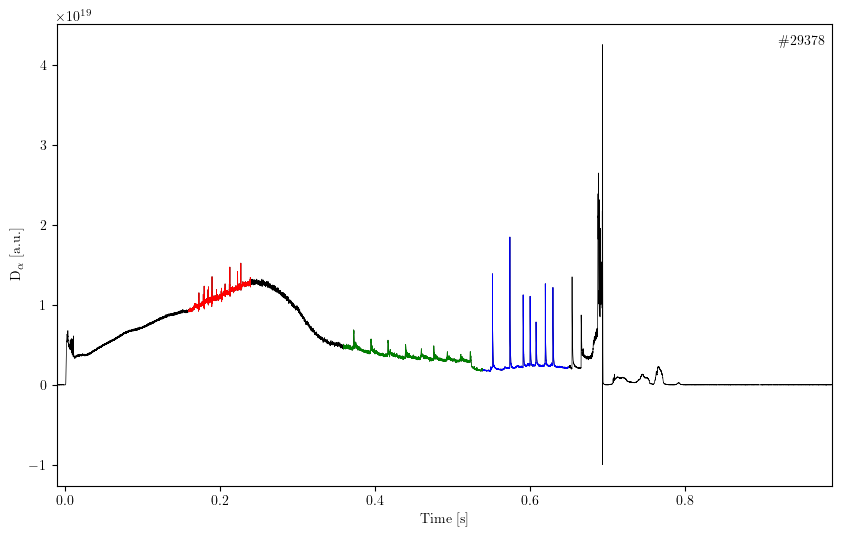

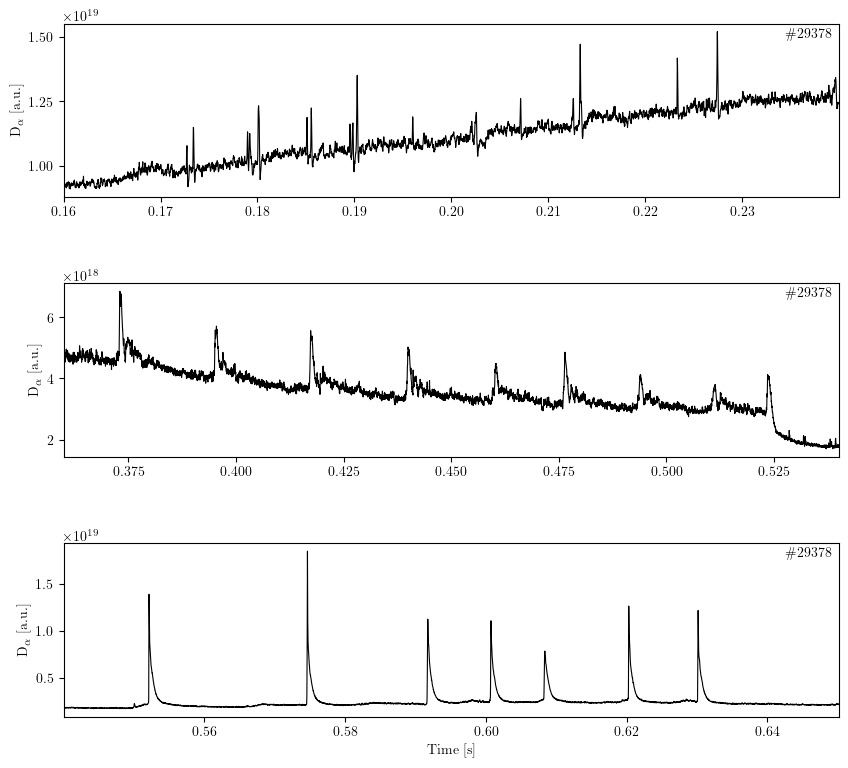

In [6]:
# Big plot of Dalpha with regions differently colours
fig1, ax1 = plt.subplots(1, 1, figsize=(10, 6))
ax1.plot(dalpha_time, dalpha_data, 'k', linewidth=0.5)

# Plots of each region separately
fig2, ax2 = plt.subplots(len(regions), 1, sharex=False, figsize=(10, 9))

for i in range(len(regions)):
    idx1 = (np.abs(dalpha_time - regions[i][0])).argmin()
    idx2 = (np.abs(dalpha_time - regions[i][1])).argmin()
    ax1.plot(dalpha_time[idx1:idx2+1], dalpha_data[idx1:idx2+1], colours[i], linewidth=0.5)
    
    ax2[i].plot(dalpha_time[idx1:idx2], dalpha_data[idx1:idx2], 'k', linewidth=0.8)
    ax2[i].tick_params(axis='x')
    ax2[i].tick_params(axis='y')
    ax2[i].set_ylabel(r"D$_\alpha$ [a.u.]")
    ax2[i].locator_params(axis='y', nbins=3)
    ax2[i].set_xlim([dalpha_time[idx1], dalpha_time[idx2]])
    ax2[i].text(.99, .975, shotlabel, ha='right', va='top', transform=ax2[i].transAxes, fontsize=10)

ax1.set_xlabel("Time [s]")
ax1.set_ylabel(r"D$_\alpha$ [a.u.]")
ax1.set_xlim([dalpha_time[0], dalpha_time[-1]])
ax1.text(.99, .975, shotlabel, ha='right', va='top', transform=ax1.transAxes, fontsize=10)

ax2[-1].set_xlabel("Time [s]")
plt.subplots_adjust(hspace=0.5)

#fig1.savefig("Full_Dalpha_plot.pdf", format="pdf", bbox_inches="tight")
#fig2.savefig("Dalpha_region_plots.pdf", format="pdf", bbox_inches="tight")

plt.show()
plt.close()

Now use tangential $D_\alpha$ data to identify crash times. Set threshold for each region so that the blue line runs below most of the peaks while avoiding baseline noise.

Alternatively, you could take a more manual approach. This sacarafices some of the more minor flashes in favour of ease-of-use.

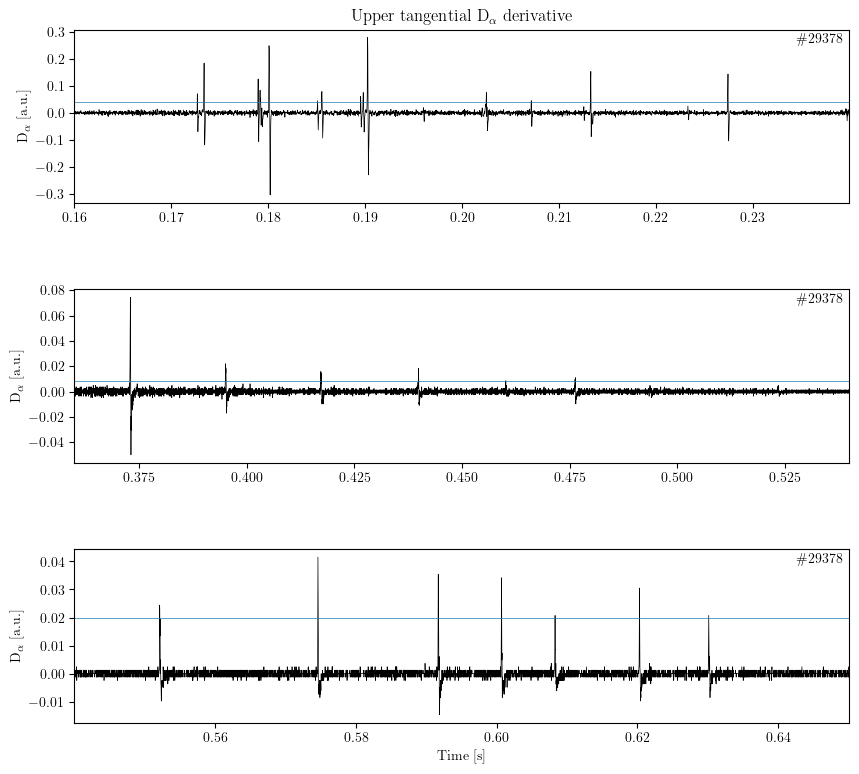

In [7]:
thresholds = [0.04, 0.008, 0.02]
figure, axes = plt.subplots(len(regions), 1, sharex=False, figsize=(10, 3*len(regions)))

for i in range(len(regions)):
    idx1 = (np.abs(utda_time - regions[i][0])).argmin()
    idx2 = (np.abs(utda_time - regions[i][1])).argmin()
    
    axes[i].plot(utda_time[idx1:idx2], np.gradient(utda_data[idx1:idx2]), "k", linewidth=0.5)
    axes[i].hlines(thresholds[i], utda_time[idx1], utda_time[idx2], linewidth=0.5)
    axes[i].set_ylabel(r"D$_\alpha$ [a.u.]")
    axes[i].locator_params(axis="y", nbins=7)
    axes[i].text(.99, .975, shotlabel, ha='right', va='top', transform=axes[i].transAxes, fontsize=10)
    axes[i].set_xlim([utda_time[idx1], utda_time[idx2]])

axes[-1].set_xlabel("Time [s]")
axes[0].set_title(r"Upper tangential D$_\alpha$ derivative")
plt.subplots_adjust(hspace=0.5)

plt.show()
plt.close()

Using thresholds defined above, find windows around crashes. Change start/end shifts as needed

In [8]:
pre_crash_windows = {}
post_crash_windows = {}
crash_times = {}

crash_times[0] = get_crash_times(utda_time, utda_data, thresholds[0], regions[0])
pre_crash_windows[0] = get_crash_adjacent_window(utda_time, utda_data, thresholds[0], regions[0], start_shift=2e-3, end_shift=0.5e-3)
post_crash_windows[0] = get_crash_adjacent_window(utda_time, utda_data, thresholds[0], regions[0], start_shift=-0.5e-3, end_shift=-2e-3)

crash_times[1] = get_crash_times(utda_time, utda_data, thresholds[1], regions[1])
pre_crash_windows[1] = get_crash_adjacent_window(utda_time, utda_data, thresholds[1], regions[1], start_shift=5e-3, end_shift=1e-3)
post_crash_windows[1] = get_crash_adjacent_window(utda_time, utda_data, thresholds[1], regions[1], start_shift=-1e-3, end_shift=-5e-3)

crash_times[2] = get_crash_times(utda_time, utda_data, thresholds[2], regions[2])
pre_crash_windows[2] = get_crash_adjacent_window(utda_time, utda_data, thresholds[2], regions[2], start_shift=5e-3, end_shift=1e-3)
post_crash_windows[2] = get_crash_adjacent_window(utda_time, utda_data, thresholds[2], regions[2], start_shift=-1e-3, end_shift=-5e-3)

Make some plots to check that windows found are sensible, readjust above as needed

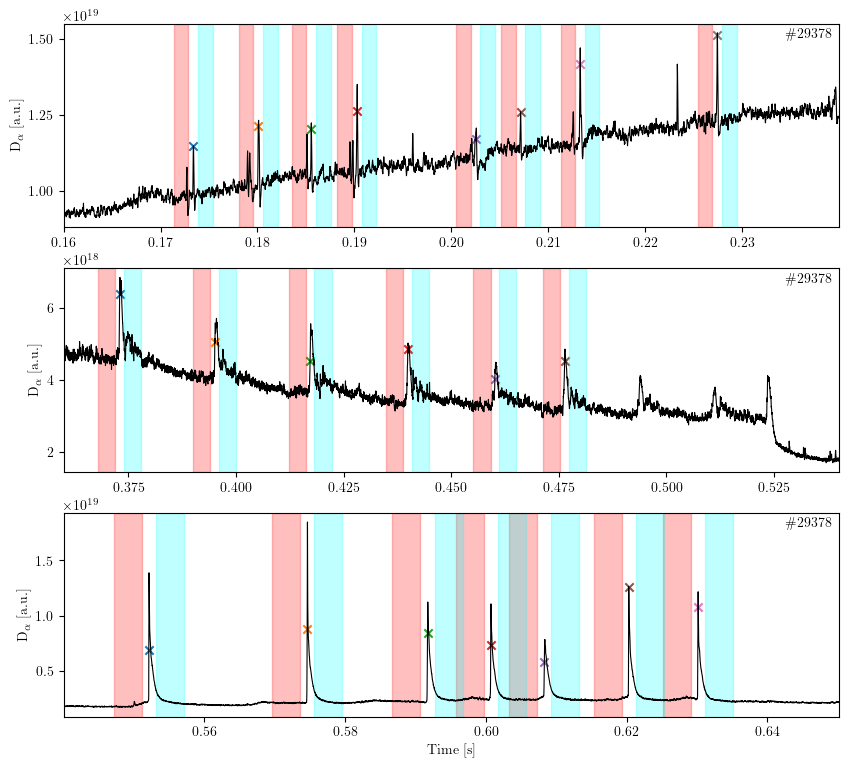

In [9]:
# Plots of each region separately with found crashes marked
fig, ax = plt.subplots(len(regions), 1, sharex=False, figsize=(10, 3*len(regions)))

for i in range(len(regions)):
    idx1 = (np.abs(dalpha_time - regions[i][0])).argmin()
    idx2 = (np.abs(dalpha_time - regions[i][1])).argmin()
    
    ax[i].plot(dalpha_time[idx1:idx2], dalpha_data[idx1:idx2], 'k', linewidth=0.8)
    ax[i].text(.99, .975, shotlabel, ha='right', va='top', transform=ax[i].transAxes, fontsize=10)
    for peak in crash_times[i]:
        crash_amplitude = dalpha_data[(np.abs(dalpha_time - peak)).argmin()]
        ax[i].scatter(peak, crash_amplitude, marker="x")
        
    for pre_window in pre_crash_windows[i]:
        ax[i].axvspan(pre_window[0], pre_window[1], alpha=0.25, color='red')

    for post_window in post_crash_windows[i]:
        ax[i].axvspan(post_window[0], post_window[1], alpha=0.25, color='cyan')
    
    ax[i].tick_params(axis='x')
    ax[i].tick_params(axis='y')
    ax[i].set_ylabel(r"D$_\alpha$ [a.u.]")
    ax[i].locator_params(axis='y', nbins=3)
    ax[i].set_xlim([dalpha_time[idx1], dalpha_time[idx2]])

ax[-1].set_xlabel("Time [s]")
plt.show()
plt.close()

Use spectrograms to define timeslices that contain particular modes

In [10]:
# Simply define a bunch of timeslices here
chirps_down = [[0.384,0.3895], [0.411, 0.416], [0.427, 0.433], [0.449, 0.455]]
elm_125 = [[0.5653,0.5665], [0.5816,0.5828], [0.595,0.596], [0.606,0.607], [0.618,0.619], [0.6267,0.628]]

centres = [0.559, 0.6127, 0.624, 0.6335, 0.644]
elm_harmonics = [[i-0.0025, i+0.0025] for i in centres]

elm_pcw = []
for i in range(len(elm_125)):
    elm_pcw.append(np.array([elm_125[i][1], crash_times[2][1:][i]-0.0005]))
    
slices = [chirps_down, elm_125, elm_harmonics, elm_pcw, pre_crash_windows[0]]

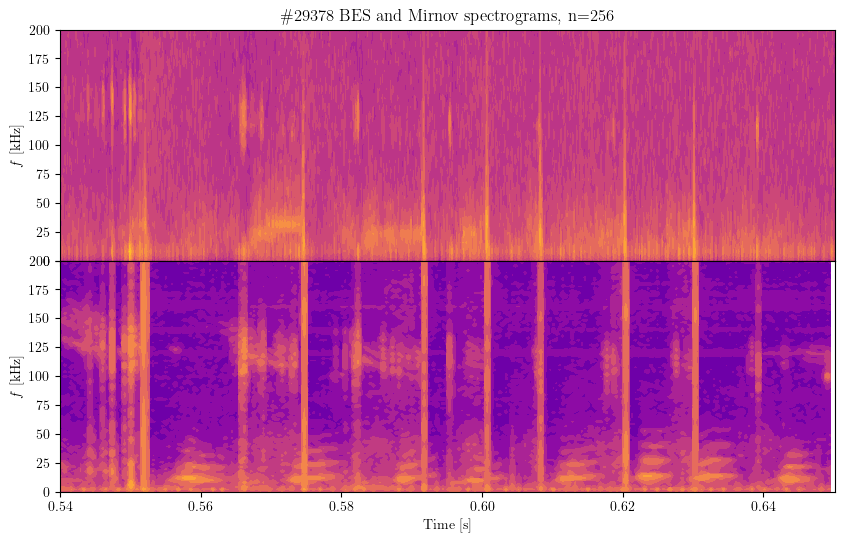

In [21]:
# Choose a region and a BES column to use for plots
region = 2
col = 6
flims = [0,200] # Frequency lims in kHz to show
fig, ax = plt.subplots(2,1, sharex=True, figsize=(10,6))

# Get spectrograms and plot them
freq1, times1, Sxx1 = sum_full_spectrogram(shot, bes_time, fluct_data, col, regions[region], n=8)
freq2, times2, Sxx2 = sum_mirnov_fluct_spectrogram(shot, mirnov_time, mirnov_data, regions[region], n=8, plot=False)
ax[0].contourf(times1,1e-3*freq1,Sxx1, 16, cmap="plasma", levels=[10**(i/10) for i in range(-80,10,5)], norm=(colors.LogNorm()))
ax[1].contourf(times2,1e-3*freq2,Sxx2, 16, cmap="plasma", levels=[10**i for i in range(-11,2)], norm=(colors.LogNorm()))

# Refine plots to particular frequency/time range
ax[0].set_ylim(flims)
ax[1].set_ylim(flims)
ax[0].set_ylabel(r"$f$ [kHz]")
ax[1].set_ylabel(r"$f$ [kHz]")

"""
# Also plot corresponing Dalpha data
idx1 = (np.abs(dalpha_time - regions[region][0])).argmin()
idx2 = (np.abs(dalpha_time - regions[region][1])).argmin()
ax[2].plot(dalpha_time[idx1:idx2+1], dalpha_data[idx1:idx2+1]*1e-19, linewidth=0.5)
ax[2].set_ylabel(r"D$_\alpha$ [a.u]")
ax[2].set_xlabel("Time [s]")


# Plot defined timeslices as vertical lines
for ws in range(len(slices)):
    for w in range(len(slices[ws])): # May wish to change colours due to poor contrast
        ax[0].vlines(slices[ws][w][0], flims[0], flims[1], colours[ws], linestyle="dashed", linewidth=0.8)
        ax[1].vlines(slices[ws][w][0], flims[0], flims[1], colours[ws], linestyle="dashed", linewidth=0.8)
        ax[0].vlines(slices[ws][w][1], flims[0], flims[1], colours[ws], linestyle="dashed", linewidth=0.8)
        ax[1].vlines(slices[ws][w][1], flims[0], flims[1], colours[ws], linestyle="dashed", linewidth=0.8)
"""

plt.xlim(left=regions[region][0], right=regions[region][1])
ax[0].set_title(shotlabel + r" BES and Mirnov spectrograms, n=" + 
            str(int(2**8)))
ax[-1].set_xlabel("Time [s]")
fig.subplots_adjust(hspace=0)
plt.savefig("viva_reg3_spectrograms.pdf", bbox_inches="tight")
plt.show()

Once happy, calculate average distance of each column from separatrix over a given timeslice. Save and/or read values from file

In [12]:
if False:
    with open("dist_in_sol.csv", "w") as f:
        f.write("Region")
        for i in range(8):
            f.write(",Col " + str(i+1))
        f.write("\n")

        for region in range(len(regions)):
            f.write(str(region+1))
            for col in range(8):
                f.write("," + str(sol_dist(equilib_time, equilib_R, equilib_Z, equilib_psi, apdpos, regions[region], col)))
            f.write("\n")

dists_in_sol = pd.read_csv(bes_data_path + "dist_in_sol.csv")

# Analysis

By this point you should be happy with the regions and timeslices within them containing intersting features.

## Filtered Signals

Look at the the shape of the signals in particular frequency modes. For example, draw out the sawtoothing.

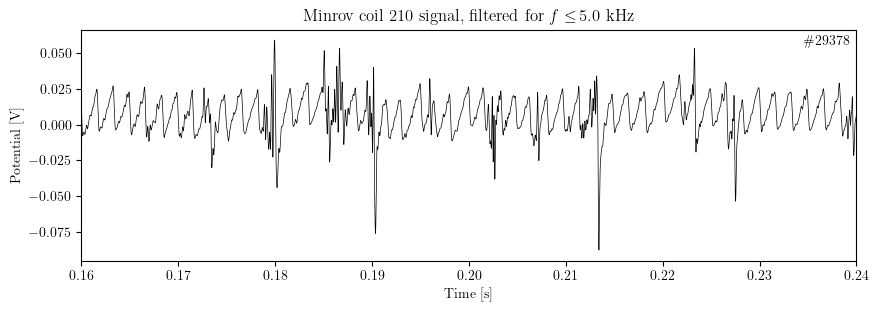

In [13]:
region = 0
coil = 2
cutoff = 5e3

idx1 = (np.abs(mirnov_time-regions[region][0])).argmin()
idx2 = (np.abs(mirnov_time-regions[region][1])).argmin()

fig, ax = plt.subplots(1,1, figsize=(10,3))
mfilt = butter_lowpass_filter(mirnov_data[coil], cutoff, f_samp_mirnov)
ax.plot(mirnov_time[idx1:idx2], mfilt[idx1:idx2], "k", linewidth=0.5)

ax.text(.99, .975, shotlabel, ha='right', va='top', transform=ax.transAxes, fontsize=10)
ax.set_xlim(regions[region])
ax.set_xlabel("Time [s]")
ax.set_ylabel("Potential [V]")
ax.set_title("Minrov coil " + str(coil_nums[coil]) + " signal, filtered for $f\leq\,$" + str(cutoff*1e-3) + " kHz")
#plt.savefig("MirnovFilt.pdf", bbox_inches="tight")
plt.show()

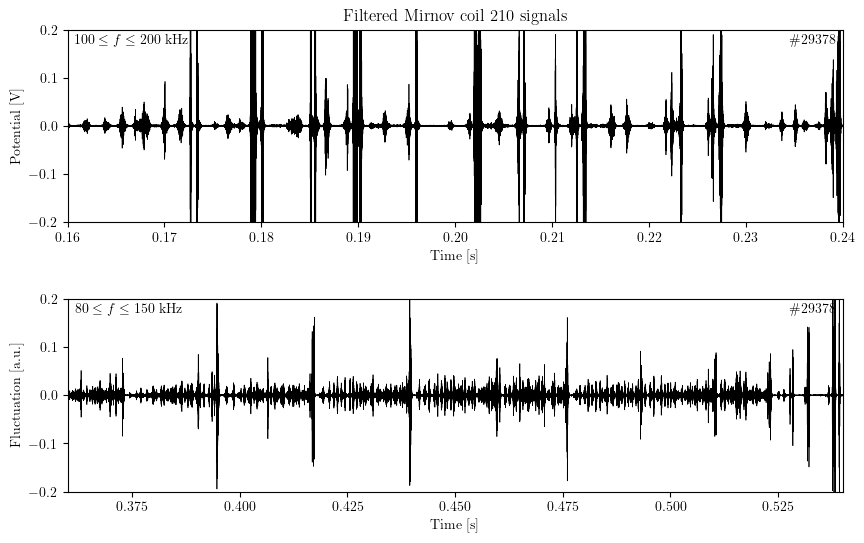

In [41]:
region = 0
coil = 2
ch = 4

idx1 = (np.abs(mirnov_time-regions[region][0])).argmin()
idx2 = (np.abs(mirnov_time-regions[region][1])).argmin()

fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=False)
mfilt1 = butter_bandpass_filter(mirnov_data[coil], 100e3, 200e3, f_samp_mirnov)
mfilt2 = butter_bandpass_filter(mirnov_data[coil], 80e3, 150e3, f_samp_mirnov)
ax[0].plot(mirnov_time, mfilt1, "k", linewidth=0.5)
ax[0].set_xlim(regions[0])
ax[1].plot(mirnov_time, mfilt2, "k", linewidth=0.5)
ax[1].set_xlim(regions[1])


ax[0].text(.99, .975, shotlabel, ha='right', va='top', transform=ax[0].transAxes, fontsize=10)
ax[1].text(.99, .975, shotlabel, ha='right', va='top', transform=ax[1].transAxes, fontsize=10)

ax[0].text(.01, .975, r"$100\leq f\leq200$ kHz", ha='left', va='top', transform=ax[0].transAxes, fontsize=10)
ax[1].text(.01, .975, r"$80\leq f\leq150$ kHz", ha='left', va='top', transform=ax[1].transAxes, fontsize=10)
ax[0].set_ylim([-0.2,0.2])
ax[1].set_ylim([-0.2,0.2])

ax[0].set_xlabel("Time [s]")
ax[1].set_xlabel("Time [s]")
ax[0].set_ylabel("Potential [V]")
ax[1].set_ylabel("Fluctuation [a.u.]")
ax[0].set_title("Filtered Mirnov coil 210 signals")
plt.subplots_adjust(hspace=0.4)

#plt.savefig("MirnovFilt2.pdf", bbox_inches="tight")
plt.show()

## Dispersion Relations and calculations of $f,\ k$ and $m$

Generate BES dispersion relations summed over pre-crash windows to give an sense of average behaviour

In [17]:
region = 1 # Choose a region to look at
for col in range(8):
    # Read avergae distance of column from separatrix
    sol_dist = np.round(dists_in_sol.loc[region].at["Col " + str(col)],2)
    
    # Title for the plot containing useful info
    plot_title = shotlabel + r", $\rho_{\rm SOL}=\,$" + str(sol_dist) + " m, pre-flashes in $t =\,$" + str(list(np.round(regions[region],2))) + " s"
    xlabel = r"Wavenumber [$\mathrm{m^{-1}}$]" # Wavenumber as this is BES data
    
    f_arr, k_arr, kf_matrix = kf_spec_sum_windows(bes_time, fluct_data, apdpos, col, pre_crash_windows[region])
    plot_dispersion_relation(f_arr, k_arr, kf_matrix, plot_title, xlabel, fmin=0e3, fmax=250e3, smooth_pts=5, conditional=False, save=False)

NameError: name 'dists_in_sol' is not defined

Generate BES & Mirnov dispersion relations for each defined window in a given set of timeslices containing modes. Chane fmin and fmax to adjust view of graphs

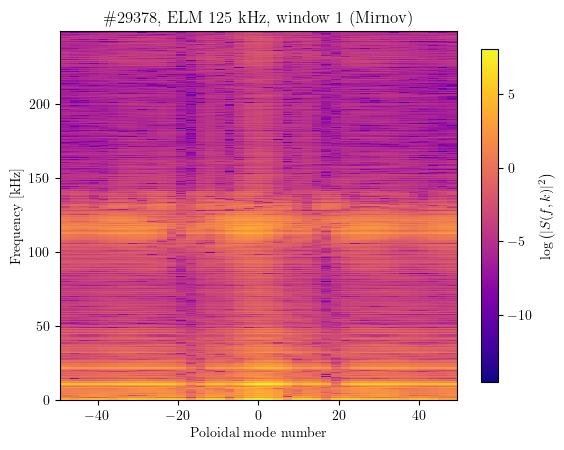

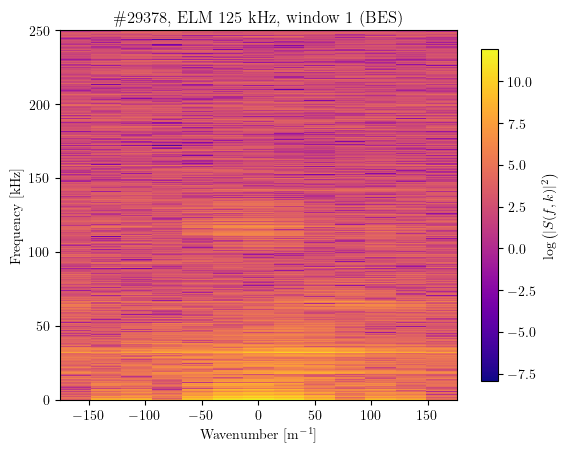

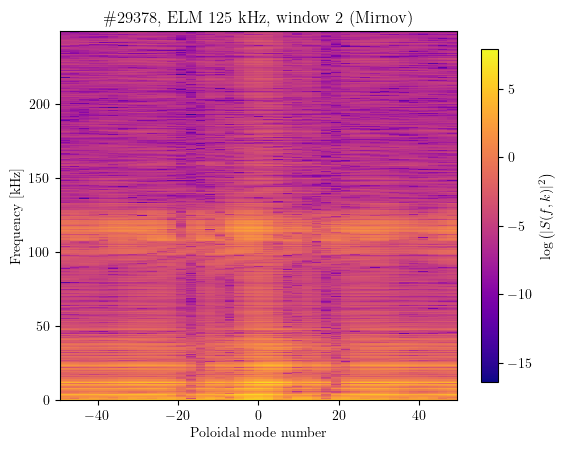

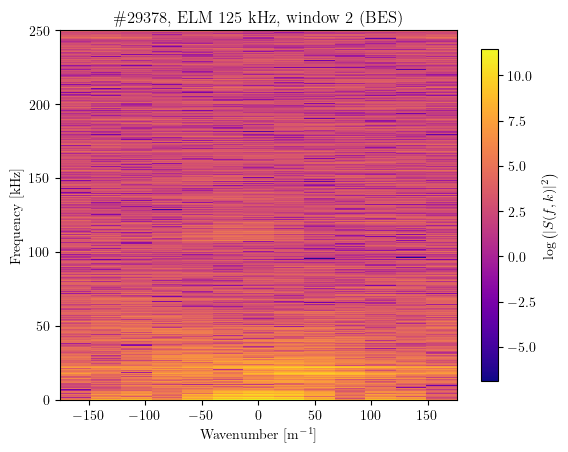

In [16]:
ws = elm_pcw[:2] # Select window to look at
ws_label = "ELM 125 kHz"
col = 6 # Choose a column to look at (best to choose where features are strongest)

for w in range(len(ws)):
    # Calculate poloidal angles of coils in the timeslice
    centre_R, centre_Z = get_magnetic_centre(equilib_time, equilib_R, equilib_Z, equilib_psi, ws[w]) # Centre of magnetic coordinate system
    coilpos_angles = np.arctan((centre_Z-coilpos[:,1])/(centre_R-coilpos[:,0])) # Trigonometry to calc angle
    
    # Mirnov
    f_arr, k_arr, kf_matrix = get_kf_spec_mirnov(mirnov_time, mirnov_data, coilpos_angles, ws[w])
    plot_title = shotlabel + ", " + ws_label + ", window " + str(w+1) + " (Mirnov)"
    plot_dispersion_relation(f_arr, k_arr, kf_matrix, plot_title, "Poloidal mode number", fmin=0e3, fmax=250e3, smooth_pts=5)
    
    # BES
    f_arr, k_arr, kf_matrix = get_kf_spec(bes_time, fluct_data, apdpos, col, ws[w])
    plot_title = shotlabel + ", " + ws_label + ", window " + str(w+1) + " (BES)"
    plot_dispersion_relation(f_arr, k_arr, kf_matrix, plot_title, r"Wavenumber [$\mathrm{m^{-1}}$]", fmin=0e3, fmax=250e3, smooth_pts=5)

Use the above dispersion relations to set frequency ranges for $k$ and $m$ calculations

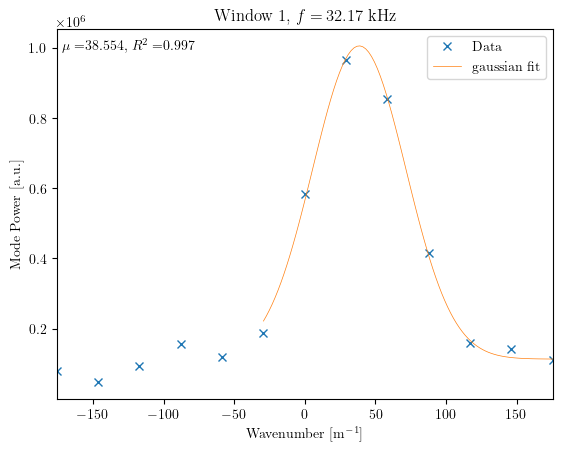

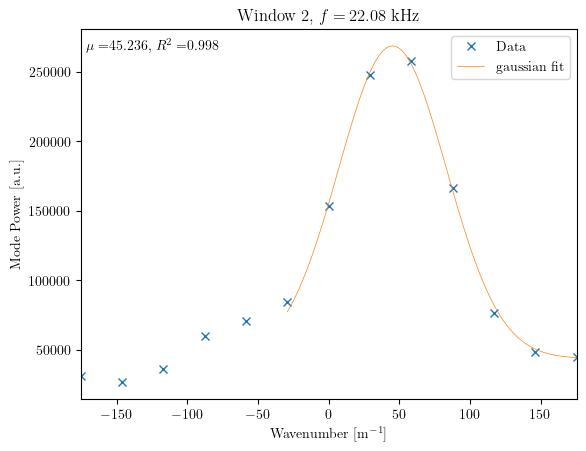

In [20]:
# One frequency range per band per window
elm_125_franges_bes = [[97500, 150000], [100000, 145000], [90000, 140000], [95000, 145000], [90000, 135000], [101000, 135000]]
elm_125_franges_mirnov = [[100000,120000], [110000,120000], [110000,120000], [118000,122000], [100000,115000], [110000,125000]]
elm_pcw_franges_bes = [[31500,32700], [21500,22800]]

elm_harmonic_franges_mirnov = np.asarray([
    [[8.0,14.0], [18.0, 26.0], [29.0, 38.0]],
    [[8.0,14.0], [20.0, 27.0], [31.0, 40.0]],
    [[10.0,16.0], [22.0, 29.0], [36.0, 42.0]],
    [[8.0,15.0], [22.0, 30.0], [34.0, 43.0]],
    [[7.0,14.0], [19.0, 26.0], [29.0, 36.0]]
])*1e3

chirps_down_franges_mirnov = np.asarray([
    [[6.0, 14.0], [14.0, 24.0], [31.0, 42.0]],
    [[5.0, 12.0], [17.0, 26.0], [37.0, 50.0]],
    [[6.0, 13.5], [14.0, 16.0], [29.0, 35.0]],
    [[7.5, 11.0], [15.0, 17.0], [29.0, 35.0]],
])*1.0e3

# Arrays for storing results of profile fitting
wavenums = []
modenums = []
fpeaks_mirnov = []
modenums_err = []
fpeaks_bes = []
wavenums_err = []

# Now run dispersion relations again, this time generating wavenmber/mode number profiles
for w in range(len(ws)):
    # BES - get dispersion relation, get wavenumber profile, fit it and return peaks.
    f_arr, k_arr, kf_matrix = get_kf_spec(bes_time, fluct_data, apdpos, col, ws[w])
    _,_, mu, err, fpeak = get_k_profile(f_arr, k_arr, kf_matrix, elm_pcw_franges_bes[w], fit=gaussian, fit_range=[5,13], plot="Window " + str(w+1), xlabel=r"Wavenumber [$\mathrm{m^{-1}}$]")
    wavenums.append(mu)
    fpeaks_bes.append(fpeak)
    wavenums_err.append(err)
    
    # Mirnov - get poloidal angles, get dispersion relation, get mode number profile, fit it and return peaks.
    """centre_R, centre_Z = get_magnetic_centre(equilib_time, equilib_R, equilib_Z, equilib_psi, ws[w]) # Centre of magnetic coordinate system
    coilpos_angles = np.arctan((centre_Z-coilpos[:,1])/(centre_R-coilpos[:,0])) # Trigonometry to calc angle
    f_arr, k_arr, kf_matrix = get_kf_spec_mirnov(mirnov_time, mirnov_data, coilpos_angles, ws[w])
    _,_, mu, err, fpeak = tmp(f_arr, k_arr, kf_matrix, elm_pcw_franges_bes[w], fit=gaussian, fit_range=[12,28], plot="Window " + str(w+1), xlabel="Poloidal mode number")
    modenums.append(mu)
    fpeaks_mirnov.append(fpeak)
    modenums_err.append(err)"""
    

In [22]:
for mode in range(len(ws)):
    k = "$" + str(np.round(wavenums[mode],3)) + "\pm" + str(np.round(wavenums_err[mode],3)) + "$"
    print(k)

$38.554\pm0.003$
$45.236\pm0.005$


In [21]:
for mode in range(len(ws)):
    k = "$" + str(np.round(wavenums[mode],3)) + "\pm" + str(np.round(wavenums_err[mode],3)) + "$"
    m = "$" + str(np.round(modenums[mode],3)) + "\pm" + str(np.round(modenums_err[mode],3)) + "$"
    print(mode+1, "&", np.round(fpeaks_bes[mode]*1e-3,1), "&", k, "\\\\")

IndexError: list index out of range

## Radial profiles from BES data

In [ ]:
ws = elm_125[1] # Pick a single timeslice to investigate

# Define frequency ranges for each window based on single-channel FFTs plotted below.
elm_125_ch_franges = [[95000,150000], [100000,160000], [100000,135000]]

def plot_bes_radial(bes_time, fluct_data, timeslice, freq_range, profile_range, plot_fft=False):
    for row in range(4):
        for col in range(8):
            f_arr, s_arr = fft_channel(bes_time, fluct_data, row*8+col, timeslice)
            small_f_arr, f_profile = get_f_profile(f_arr, kf_matrix, profile_range, plot=True, vlines=freq_range, smooth_pts=5)

In [ ]:
plot_bes_radial(bes_time, fluct_data, ws, elm_125_ch_franges[1], [75000,175000], plot_fft=False)